# Problem Statement

[An article in the Dallas Observer](https://www.dallasobserver.com/restaurants/dallas-restaurant-inspections-suffer-from-delays-poor-record-keeping-and-overworked-staff-10697588) unearthed a massive problem in the city's ability to follow up on restaurants requiring reinspection due to a low grade upon original inspection.  Dallas states that out of a scale from 1-100, any facility that scores between 70-79 requires reinspection within 30 days, between 60-69 requires reinspection within 10 days, and below 60 requires reinspection ASAP.

The article points out many flaws in the city's ability to reinspect restaurants within its own self-imposed timeframes,.  Until the department can hopefully become better-staffed, I am looking to build a classification model that can predict how a restaurant will perform upon reinspection.  This way, if the city is still struggling to reinspect restaurants in a timely manner, they can refer to the model in order to prioritize certain facilities to reinspect.



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist


%matplotlib inline

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data Collection

In [2]:
df = pd.read_csv('./data/Restaurant_and_Food_Establishment_Inspections__October_2016_to_Present_.csv')

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10,97,103,105,106,107,109,110) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
0,FRESHII,Routine,10/31/2018,96,2414,VICTORY PARK,NaN,LN,NaN,2414 VICTORY PARK LN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2018,FY2019,"2414 VICTORY PARK LN\n(32.787625, -96.809294)"
1,MICKLE CHICKEN,Routine,10/30/2019,100,3203,CAMP WISDOM,W,RD,NaN,3203 W CAMP WISDOM RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2019,FY2020,"3203 W CAMP WISDOM RD\n(32.662584, -96.873446)"
2,WORLD TRADE CENTER MARKET,Routine,11/03/2016,100,2050,STEMMONS,N,FRWY,NaN,2050 N STEMMONS FRWY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov 2016,FY2017,"2050 N STEMMONS FRWY\n(32.801934, -96.825878)"
3,DUNKIN DONUTS,Routine,10/30/2019,99,8008,HERB KELLEHER,NaN,WAY,C2174,8008 HERB KELLEHER WAY STE# C2174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2019,FY2020,8008 HERB KELLEHER WAY STE# C2174
4,CANVAS HOTEL - 6TH FLOOR,Routine,06/11/2018,100,1325,LAMAR,S,ST,NaN,1325 S LAMAR ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jun 2018,FY2018,"1325 S LAMAR ST\n(39.69335, -105.067425)"


# Data Cleaning

In [4]:
df.shape

(44656, 114)

In [5]:
df.isnull().sum().sort_values(ascending = False).tail()

Street Number        0
Inspection Score     0
Inspection Date      0
Inspection Type      0
Lat Long Location    0
dtype: int64

In [6]:
df.loc[df['Restaurant Name'].isnull()]

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
20592,NaN,Routine,02/21/2018,86,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2018,FY2018,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
21643,NaN,Routine,08/28/2017,87,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2017,FY2017,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
24064,NaN,Routine,07/28/2017,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jul 2017,FY2017,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
24612,NaN,Routine,08/06/2018,91,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2018,FY2018,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
26713,NaN,Routine,02/02/2017,88,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2017,FY2017,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
33050,NaN,Routine,11/27/2017,80,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov 2017,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
34370,NaN,Routine,06/13/2018,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jun 2018,FY2018,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
39616,NaN,Routine,05/22/2018,92,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2018,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
43261,NaN,Routine,05/31/2017,91,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2017,FY2017,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
43934,NaN,Routine,01/03/2018,84,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan 2018,FY2018,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"


In [7]:
df.loc[df['Street Number'] == 4243].head()

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
4333,WILLIAMS CHICKEN,Routine,08/14/2019,94,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2019,FY2019,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
10552,WILLIAMS CHICKEN,Routine,02/12/2020,92,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2020,FY2020,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
14015,WILLIAMS CHICKEN,Routine,02/11/2019,97,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2019,FY2019,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
20592,NaN,Routine,02/21/2018,86,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2018,FY2018,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
21643,NaN,Routine,08/28/2017,87,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2017,FY2017,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"


While the null restaurants seem to line up with an actual restaurant, I could not find evidence that this location was an identical or different restaurant during time of inspection.  Instead of imputing what I assume is the restaurant name, I will impute the name of unkown.

In [8]:
df.dtypes.value_counts()

object     87
float64    25
int64       2
dtype: int64

In [9]:
dtypes_df = pd.DataFrame(df.dtypes)

object_cols = dtypes_df.loc[dtypes_df[0] == 'object'].index

float_cols = dtypes_df.loc[dtypes_df[0] == 'float64'].index



In [10]:
df[object_cols] = df[object_cols].fillna(' ')

In [11]:
df['calculated_score'] = 100 - df[float_cols].sum(axis = 1)

In [12]:
df.loc[df['Inspection Score'] != df['calculated_score']]

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score
20,JERSEY MIKES SUBS,Routine,10/04/2018,89,14060,DALLAS,,PKWY,400,14060 DALLAS PKWY STE 400,...,,,,NaN,,,Oct 2018,FY2019,"14060 DALLAS PKWY STE 400\n(32.938693, -96.821...",100.0
30,CANTINA LAREDO,Routine,10/30/2019,0,6025,ROYAL,,LN,#250,6025 ROYAL LN #250,...,,,,NaN,,,Oct 2019,FY2020,"6025 ROYAL LN #250\n(32.894884, -96.802798)",100.0
83,CIELO CREATIONS,Follow-up,03/27/2019,88,2711,HASKELL,N,AVE,#C3,2711 N HASKELL AVE #C3,...,,,,NaN,,,Mar 2019,FY2019,"2711 N HASKELL AVE #C3\n(32.807044, -96.792783)",100.0
308,PIZZA HUT,Routine,06/12/2019,83,222,CONTINENTAL,,AVE,,222 CONTINENTAL AVE,...,,,,NaN,,,Jun 2019,FY2019,"222 CONTINENTAL AVE\n(32.78378, -96.814079)",100.0
1579,PARKIT MKT,Routine,11/06/2019,92,4724,GREENVILLE,,AVE,#A,4724 GREENVILLE AVE #A,...,,,,NaN,,,Nov 2019,FY2020,"4724 GREENVILLE AVE #A\n(32.84534, -96.769994)",91.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42734,A W BROWN FELLOWSHIP CHURCH,Routine,04/18/2018,84,6901,WESTMORELAND,S,RD,,6901 S WESTMORELAND RD,...,,,,NaN,,,Apr 2018,FY2018,"6901 S WESTMORELAND RD\n(32.663499, -96.881698)",100.0
43052,SAMAD CAFE,Routine,04/25/2017,82,2706,MANOR,,WAY,,2706 MANOR WAY,...,,,,NaN,,,Apr 2017,FY2017,"2706 MANOR WAY\n(32.827271, -96.839715)",85.0
43458,KROGER #689 DELI,Routine,10/29/2018,97,17194,PRESTON,,RD,,17194 PRESTON RD,...,,,,NaN,,,Oct 2018,FY2019,"17194 PRESTON RD\n(32.985862, -96.803703)",100.0
43960,DRIP COFFEE COMPANY,Routine,09/23/2018,92,3888,OAK LAWN,,AVE,#106,3888 OAK LAWN AVE #106,...,,,,NaN,,,Sep 2018,FY2018,"3888 OAK LAWN AVE #106\n(32.816303, -96.802317)",91.0


81 restaurants have an inspection score that does not match up with the calculated score.  Since I am ultimately using NLP from the inspection details and memos, I'm going to utilize the calculated score to make my predictions.

In [13]:
df.drop(columns=float_cols, inplace= True)
df.drop(columns='Inspection Score', inplace= True)


Keeping in my float columns would violate colinearity

Since this project is based on NLP, I will be merging all of the violation detail, description, and memo columns, which should handle the nulls.  Any leftover nulls after that merge likely relate to a restaurant having no violations to note, which is important data.  11 restaurant names are null.  If there is an address given, I will probably keep them.  Additionally, I will merge the address columns with names to help the model account for different locations of the same restaurant.

In [14]:
df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])

df.loc[df[df.columns[3:]].duplicated()].sort_values(by = "Inspection Date")

df = df.sort_values(by = 'Inspection Date')

df.reset_index(inplace = True)

df.drop(columns= 'index', inplace = True)

In [15]:
df['next_inspection_score'] = df.groupby(['Restaurant Name', 'Street Name', 'Street Number'])['calculated_score'].shift(-1)

In [16]:
df['days_since_last_insp'] = df.groupby(['Restaurant Name', 'Street Name', 'Street Number'])['Inspection Date'].diff()

In [17]:
df['Inspection Type'].value_counts()

Routine      43990
Follow-up      641
Complaint       25
Name: Inspection Type, dtype: int64

In [18]:
df['inspection_count'] = df.groupby(['Restaurant Name', 'Street Address','Inspection Year']).cumcount()+1


In [19]:
df['inspection_count'].value_counts()

1     26576
2     16042
3      1703
4       248
5        61
6        16
7         6
8         2
10        1
9         1
Name: inspection_count, dtype: int64

In [20]:
df.loc[df['inspection_count'] == 9]

,Restaurant Name,Inspection Type,Inspection Date,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,Zip Code,...,Violation Description - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score,next_inspection_score,days_since_last_insp,inspection_count
25126,MAMA'S DAUGHTER'S DINER,Routine,2018-07-20,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jul 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",71.0,81.0,114 days,9


In [21]:
df.loc[df['Restaurant Name'] == "MAMA'S DAUGHTER'S DINER"]

,Restaurant Name,Inspection Type,Inspection Date,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,Zip Code,...,Violation Description - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score,next_inspection_score,days_since_last_insp,inspection_count
3754,MAMA'S DAUGHTER'S DINER,Routine,2017-01-10,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jan 2017,FY2017,"2610 ROYAL LN\n(32.446632, -97.701097)",95.0,89.0,NaT,1
4770,MAMA'S DAUGHTER'S DINER,Routine,2017-02-06,2014,IRVING,,BLVD,,2014 IRVING BLVD,75207,...,,,,Feb 2017,FY2017,"2014 IRVING BLVD\n(32.795151, -96.828667)",85.0,86.0,NaT,1
10415,MAMA'S DAUGHTER'S DINER,Routine,2017-06-30,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jun 2017,FY2017,"2610 ROYAL LN\n(32.446632, -97.701097)",89.0,67.0,171 days,2
12022,MAMA'S DAUGHTER'S DINER,Routine,2017-08-16,2014,IRVING,,BLVD,,2014 IRVING BLVD,75207,...,,,,Aug 2017,FY2017,"2014 IRVING BLVD\n(32.795151, -96.828667)",86.0,90.0,191 days,2
16941,MAMA'S DAUGHTER'S DINER,Routine,2017-12-22,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Dec 2017,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",67.0,75.0,175 days,1
17696,MAMA'S DAUGHTER'S DINER,Routine,2018-01-16,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jan 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",75.0,69.0,25 days,2
18059,MAMA'S DAUGHTER'S DINER,Routine,2018-01-24,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jan 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",69.0,73.0,8 days,3
18597,MAMA'S DAUGHTER'S DINER,Routine,2018-02-07,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Feb 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",73.0,63.0,14 days,4
18776,MAMA'S DAUGHTER'S DINER,Routine,2018-02-10,2014,IRVING,,BLVD,,2014 IRVING BLVD,75207,...,,,,Feb 2018,FY2018,"2014 IRVING BLVD\n(32.795151, -96.828667)",90.0,83.0,178 days,1
19716,MAMA'S DAUGHTER'S DINER,Routine,2018-03-07,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Mar 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",63.0,57.0,28 days,5


Even though we know these are follow-up visits, they are not being listed as follow-up.  Since I am looking to predict the future score, I will drop that column.

In [22]:
df.drop(columns= 'Inspection Type', inplace = True)

In [23]:
df.isnull().sum().sort_values().tail(1)

days_since_last_insp    8483
dtype: int64

Even though we want to prevent data loss, the act of trying to predict the next inspection score makes us have to lag our data.  As we saw previously, I did a lag of one, so I have to drop every restaurant's first score.

In [24]:
df.dropna(inplace = True)

df.reset_index(inplace= True)

df.drop(columns = 'index', inplace = True)

In [25]:
string_cols = df.dtypes.loc[df.dtypes.values == 'object'].index

In [26]:
str_to_drop = string_cols[1:6]

In [27]:
df.drop(columns = str_to_drop, inplace = True)

In [28]:
df.drop(columns = df.columns[2:3], inplace = True)

In [29]:
string_cols = df.dtypes.loc[df.dtypes.values == 'object'].index

In [30]:
df['alltext'] = df[string_cols[:-1]].apply(
    lambda x: ' '.join(x.dropna().astype(str)), axis = 1)

# code is from Ed Chum on https://stackoverflow.com/questions/33098383/merge-multiple-column-values-into-one-column-in-python-pandas


In [31]:
df.drop(columns = string_cols, inplace=True)

In [32]:
df.head()

,Inspection Date,calculated_score,next_inspection_score,days_since_last_insp,inspection_count,alltext
0,2016-10-04,96.0,100.0,0 days,2,LA AZTECA MEAT MARKET GROCERY 75220 *25 Contro...
1,2016-10-05,97.0,94.0,0 days,2,"TIENDA HISPANO 75203 *45 Walls and ceilings, s..."
2,2016-10-10,91.0,90.0,0 days,2,"THE MERCURY GRILL 75230 *35 Eating food, chewi..."
3,2016-10-13,80.0,81.0,7 days,2,SPRING CREEK BARBEQUE 75230 *19 Backflow preve...
4,2016-10-14,81.0,73.0,11 days,2,MI HONDURAS 75229 *01 Cooling -- within 2 hour...


In [33]:
letter_grades = []

for i in df['next_inspection_score']:
    if i < 60:
        letter_grades.append('F')
    if i >= 60 and i < 70:
        letter_grades.append('D')
    if i >= 70 and i < 80:
        letter_grades.append('C')
    if i >= 80 and i < 90:
        letter_grades.append('B')
    if i >= 90:
        letter_grades.append('A')



In [34]:
df['next_inspection_grade'] = letter_grades

In [35]:
df.head()

,Inspection Date,calculated_score,next_inspection_score,days_since_last_insp,inspection_count,alltext,next_inspection_grade
0,2016-10-04,96.0,100.0,0 days,2,LA AZTECA MEAT MARKET GROCERY 75220 *25 Contro...,A
1,2016-10-05,97.0,94.0,0 days,2,"TIENDA HISPANO 75203 *45 Walls and ceilings, s...",A
2,2016-10-10,91.0,90.0,0 days,2,"THE MERCURY GRILL 75230 *35 Eating food, chewi...",A
3,2016-10-13,80.0,81.0,7 days,2,SPRING CREEK BARBEQUE 75230 *19 Backflow preve...,B
4,2016-10-14,81.0,73.0,11 days,2,MI HONDURAS 75229 *01 Cooling -- within 2 hour...,C


In [36]:
df['days_since_last_insp'] = df['days_since_last_insp'].astype(int)/24/60/60/1000000000

In [37]:
df.head()

,Inspection Date,calculated_score,next_inspection_score,days_since_last_insp,inspection_count,alltext,next_inspection_grade
0,2016-10-04,96.0,100.0,0.0,2,LA AZTECA MEAT MARKET GROCERY 75220 *25 Contro...,A
1,2016-10-05,97.0,94.0,0.0,2,"TIENDA HISPANO 75203 *45 Walls and ceilings, s...",A
2,2016-10-10,91.0,90.0,0.0,2,"THE MERCURY GRILL 75230 *35 Eating food, chewi...",A
3,2016-10-13,80.0,81.0,7.0,2,SPRING CREEK BARBEQUE 75230 *19 Backflow preve...,B
4,2016-10-14,81.0,73.0,11.0,2,MI HONDURAS 75229 *01 Cooling -- within 2 hour...,C


### Count Vectorizer

In [38]:
list_of_strings = df['alltext']

In [39]:
cvec = CountVectorizer(lowercase = True, # turn everything to lower case
                       ngram_range = (1, 3),
                      stop_words= 'english',
                       max_features= 2100) # for EDA, I will look at 1 word and 2 word phrases

# data run through cvec must be transformed
X_text = cvec.fit_transform(list_of_strings)

In [40]:
X_text_df = pd.DataFrame(X_text.toarray(),
                      columns = cvec.get_feature_names())


In [41]:
X_text_df.head()

,02,02 cold,02 cold hold,03,03 food,03 food products,07,07 food,07 food safe,09,...,õ228 111,õ228 111 title,õ228 206,õ228 206 title,õ228 71,õ228 71 title,õ228 73,õ228 73 title,õ228 78,õ228 78 title
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0


# EDA

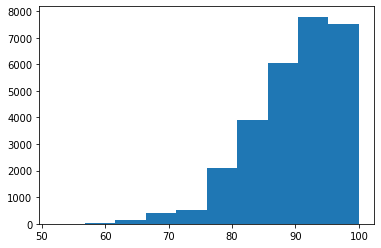

In [42]:
plt.hist(df['calculated_score'], bins = 10);

In [43]:
len(df.loc[df['calculated_score'] >= 80]) / len(df)

0.9436495939817907

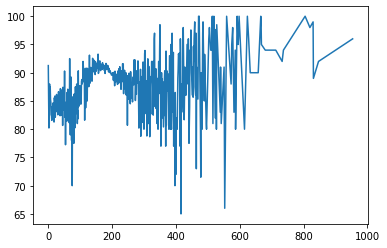

In [44]:
plt.plot(df.groupby(['days_since_last_insp'])['calculated_score'].mean())

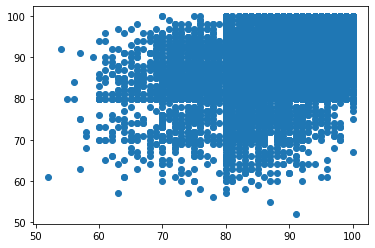

In [45]:
plt.scatter(df['calculated_score'], df['next_inspection_score'])

In [46]:
df.corr()

,calculated_score,next_inspection_score,days_since_last_insp,inspection_count
calculated_score,1.000000,0.554437,0.078654,-0.079388
next_inspection_score,0.554437,1.000000,0.105646,-0.088987
days_since_last_insp,0.078654,0.105646,1.000000,-0.376266
inspection_count,-0.079388,-0.088987,-0.376266,1.000000


In [47]:
df.groupby(df['next_inspection_grade']).corr()

calculated_score  \
next_inspection_grade                                           
A                     calculated_score               1.000000   
                      next_inspection_score          0.404955   
                      days_since_last_insp           0.039460   
                      inspection_count              -0.059159   
B                     calculated_score               1.000000   
                      next_inspection_score          0.226214   
                      days_since_last_insp           0.032256   
                      inspection_count              -0.031986   
C                     calculated_score               1.000000   
                      next_inspection_score          0.152514   
                      days_since_last_insp           0.034341   
                      inspection_count              -0.027236   
D                     calculated_score               1.000000   
                      next_inspection_score         -0.013831   
                      days_since_last_insp           0.092295   
                      inspection_count              -0.098515   
F                     calculated_score               1.000000   
                      next_inspection_score         -0.418728   
                      days_since_last_insp           0.214949   
                      inspection_count              -0.576736   

                                             next_inspection_score  \
next_inspection_grade                                                
A                     calculated_score                    0.404955   
                      next_inspection_score               1.000000   
                      days_since_last_insp                0.025061   
                      inspection_count                   -0.035050   
B                     calculated_score                    0.226214   
                      next_inspection_score               1.000000   
                      days_since_last_insp                0.037650   
                      inspection_count                   -0.026010   
C                     calculated_score                    0.152514   
                      next_inspection_score               1.000000   
                      days_since_last_insp                0.056899   
                      inspection_count                   -0.024709   
D                     calculated_score                   -0.013831   
                      next_inspection_score               1.000000   
                      days_since_last_insp                0.058561   
                      inspection_count                   -0.080841   
F                     calculated_score                   -0.418728   
                      next_inspection_score               1.000000   
                      days_since_last_insp                0.106281   
                      inspection_count                   -0.065083   

                                             days_since_last_insp  \
next_inspection_grade                                               
A                     calculated_score                   0.039460   
                      next_inspection_score              0.025061   
                      days_since_last_insp               1.000000   
                      inspection_count                  -0.307170   
B                     calculated_score                   0.032256   
                      next_inspection_score              0.037650   
                      days_since_last_insp               1.000000   
                      inspection_count                  -0.417723   
C                     calculated_score                   0.034341   
                      next_inspection_score              0.056899   
                      days_since_last_insp               1.000000   
                      inspection_count                  -0.482717   
D                     calculated_score                   0.092295   
                      next_inspection_

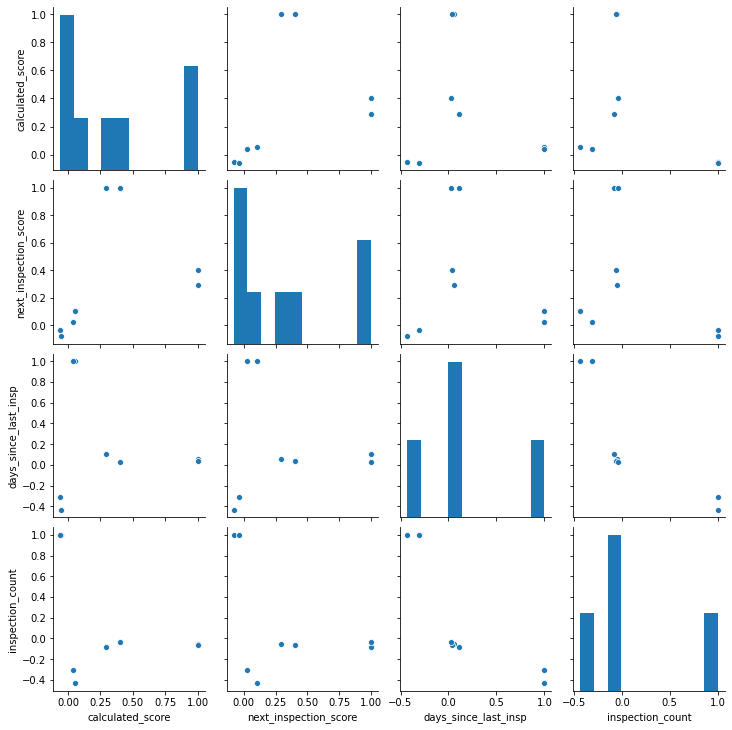

In [48]:
sns.pairplot(df.groupby(df['next_inspection_grade'] == 'A').corr())

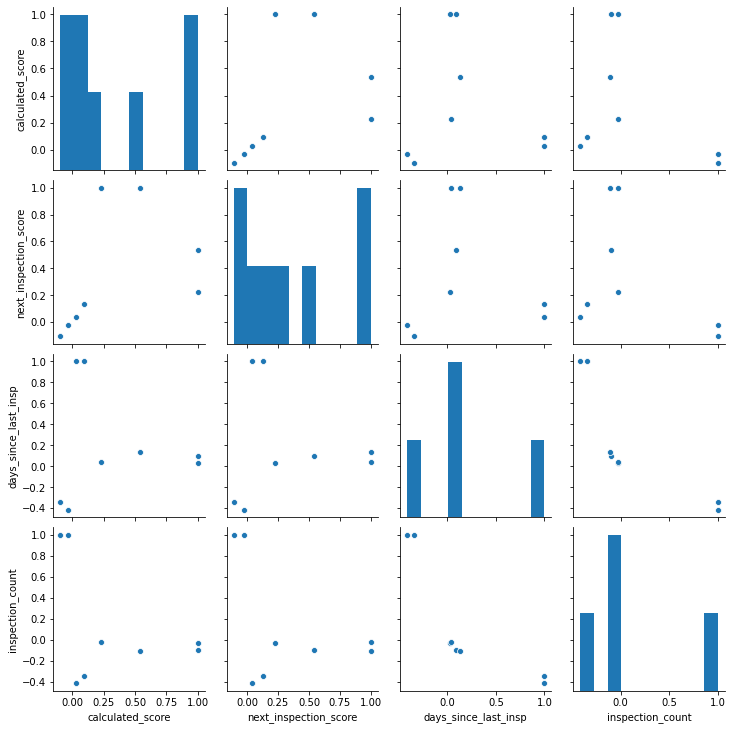

In [49]:
sns.pairplot(df.groupby(df['next_inspection_grade'] == 'B').corr())

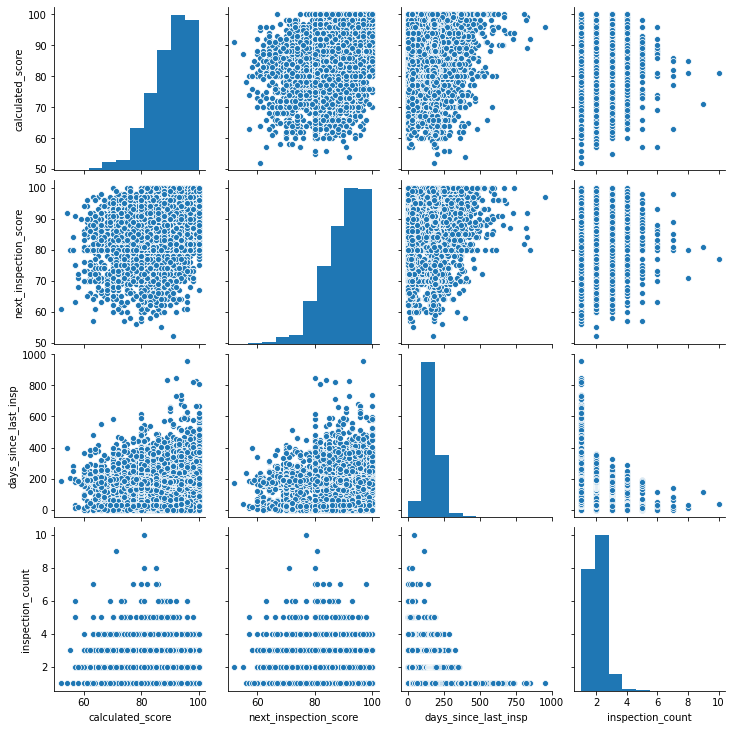

In [50]:
sns.pairplot(df)

In [51]:
df['calculated_score'].groupby(df['inspection_count']).mean()

inspection_count
1     90.151705
2     90.433203
3     87.414116
4     83.310811
5     82.288136
6     82.466667
7     78.833333
8     83.000000
9     71.000000
10    81.000000
Name: calculated_score, dtype: float64

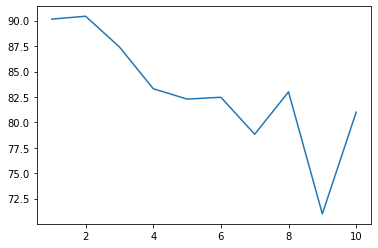

In [52]:
plt.plot(df['calculated_score'].groupby(df['inspection_count']).mean())

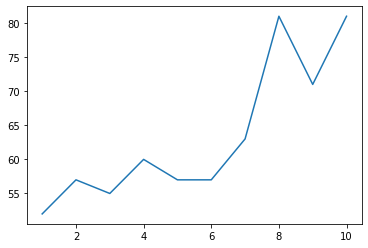

In [53]:
plt.plot(df['calculated_score'].groupby(df['inspection_count']).min())

In [54]:
X_text_df.head()

,02,02 cold,02 cold hold,03,03 food,03 food products,07,07 food,07 food safe,09,...,õ228 111,õ228 111 title,õ228 206,õ228 206 title,õ228 71,õ228 71 title,õ228 73,õ228 73 title,õ228 78,õ228 78 title
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0


In [55]:
df.drop(columns = ['Inspection Date', 'alltext'], inplace=True)

In [56]:
X_text_df[df.columns] = df

In [57]:
X_text_df

,02,02 cold,02 cold hold,03,03 food,03 food products,07,07 food,07 food safe,09,...,õ228 71 title,õ228 73,õ228 73 title,õ228 78,õ228 78 title,calculated_score,next_inspection_score,days_since_last_insp,inspection_count,next_inspection_grade
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,96.0,100.0,0.0,2,A
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,97.0,94.0,0.0,2,A
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,91.0,90.0,0.0,2,A
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,80.0,81.0,7.0,2,B
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,81.0,73.0,11.0,2,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28442,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,80.0,91.0,166.0,1,A
28443,1,1,1,1,1,1,0,0,0,1,...,1,1,1,0,0,70.0,95.0,197.0,1,A
28444,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,69.0,89.0,190.0,1,B
28445,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,96.0,95.0,369.0,1,A


In [98]:
X = X_text_df.drop(columns = ['next_inspection_score', 'next_inspection_grade']) #predictive variable
y = X_text_df['next_inspection_grade']

In [59]:
X.shape

(28447, 2103)

In [60]:
y.shape

(28447,)

# Modeling

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 63, stratify = y)

# Baseline

In [100]:
y.value_counts()/len(df)

4    0.603825
3    0.349316
2    0.038668
1    0.007839
0    0.000352
Name: next_inspection_grade, dtype: float64

Baseline model would perform at 60.3% accuracy, which would be if my model predicted A every time.

In [102]:
pipe = Pipeline([ #instantiate transformers and model 
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(random_state = 63))
])

# set hyperparameters

pipe_params = {'tfidf__use_idf'  : [True, False], #toggle between use of TFIDF
              'lr__solver': ['lbfgs'],
              'lr__penalty': ['l2']}

gs = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 3, # cross validation of 3
                 scoring = 'accuracy',
                 verbose = 2)

In [103]:
logreg1 = gs.fit(X_train,y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] lr__penalty=l1, lr__solver=liblinear, tfidf__use_idf=True .......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  lr__penalty=l1, lr__solver=liblinear, tfidf__use_idf=True, total=  10.1s
[CV] lr__penalty=l1, lr__solver=liblinear, tfidf__use_idf=True .......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


[CV]  lr__penalty=l1, lr__solver=liblinear, tfidf__use_idf=True, total=  11.4s
[CV] lr__penalty=l1, lr__solver=liblinear, tfidf__use_idf=True .......
[CV]  lr__penalty=l1, lr__solver=liblinear, tfidf__use_idf=True, total=   8.5s
[CV] lr__penalty=l1, lr__solver=liblinear, tfidf__use_idf=False ......
[CV]  lr__penalty=l1, lr__solver=liblinear, tfidf__use_idf=False, total=   9.2s
[CV] lr__penalty=l1, lr__solver=liblinear, tfidf__use_idf=False ......
[CV]  lr__penalty=l1, lr__solver=liblinear, tfidf__use_idf=False, total=   8.7s
[CV] lr__penalty=l1, lr__solver=liblinear, tfidf__use_idf=False ......
[CV]  lr__penalty=l1, lr__solver=liblinear, tfidf__use_idf=False, total=   8.4s
[CV] lr__penalty=l1, lr__solver=lbfgs, tfidf__use_idf=True ...........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  lr__penalty=l1, lr__solver=lbfgs, tfidf__use_idf=True, total=   2.9s
[CV] lr__penalty=l1, lr__solver=lbfgs, tfidf__use_idf=True ...........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  lr__penalty=l1, lr__solver=lbfgs, tfidf__use_idf=True, total=   3.1s
[CV] lr__penalty=l1, lr__solver=lbfgs, tfidf__use_idf=True ...........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  lr__penalty=l1, lr__solver=lbfgs, tfidf__use_idf=True, total=   2.5s
[CV] lr__penalty=l1, lr__solver=lbfgs, tfidf__use_idf=False ..........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  lr__penalty=l1, lr__solver=lbfgs, tfidf__use_idf=False, total=   2.7s
[CV] lr__penalty=l1, lr__solver=lbfgs, tfidf__use_idf=False ..........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  lr__penalty=l1, lr__solver=lbfgs, tfidf__use_idf=False, total=   2.8s
[CV] lr__penalty=l1, lr__solver=lbfgs, tfidf__use_idf=False ..........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[CV]  lr__penalty=l1, lr__solver=lbfgs, tfidf__use_idf=False, total=   2.4s
[CV] lr__penalty=l1, lr__solver=none, tfidf__use_idf=True ............


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)


[CV]  lr__penalty=l1, lr__solver=none, tfidf__use_idf=True, total=   2.8s
[CV] lr__penalty=l1, lr__solver=none, tfidf__use_idf=True ............


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)


[CV]  lr__penalty=l1, lr__solver=none, tfidf__use_idf=True, total=   3.0s
[CV] lr__penalty=l1, lr__solver=none, tfidf__use_idf=True ............


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)


[CV]  lr__penalty=l1, lr__solver=none, tfidf__use_idf=True, total=   2.6s
[CV] lr__penalty=l1, lr__solver=none, tfidf__use_idf=False ...........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)


[CV]  lr__penalty=l1, lr__solver=none, tfidf__use_idf=False, total=   2.9s
[CV] lr__penalty=l1, lr__solver=none, tfidf__use_idf=False ...........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)


[CV]  lr__penalty=l1, lr__solver=none, tfidf__use_idf=False, total=   2.7s
[CV] lr__penalty=l1, lr__solver=none, tfidf__use_idf=False ...........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)


[CV]  lr__penalty=l1, lr__solver=none, tfidf__use_idf=False, total=   2.4s
[CV] lr__penalty=l2, lr__solver=liblinear, tfidf__use_idf=True .......
[CV]  lr__penalty=l2, lr__solver=liblinear, tfidf__use_idf=True, total=   6.7s
[CV] lr__penalty=l2, lr__solver=liblinear, tfidf__use_idf=True .......
[CV]  lr__penalty=l2, lr__solver=liblinear, tfidf__use_idf=True, total=   6.8s
[CV] lr__penalty=l2, lr__solver=liblinear, tfidf__use_idf=True .......
[CV]  lr__penalty=l2, lr__solver=liblinear, tfidf__use_idf=True, total=  11.0s
[CV] lr__penalty=l2, lr__solver=liblinear, tfidf__use_idf=False ......
[CV]  lr__penalty=l2, lr__solver=liblinear, tfidf__use_idf=False, total=   7.7s
[CV] lr__penalty=l2, lr__solver=liblinear, tfidf__use_idf=False ......
[CV]  lr__penalty=l2, lr__solver=liblinear, tfidf__use_idf=False, total=   7.5s
[CV] lr__penalty=l2, lr__solver=liblinear, tfidf__use_idf=False ......
[CV]  lr__penalty=l2, lr__solver=liblinear, tfidf__use_idf=False, total=   6.5s
[CV] lr__penalty=l2, l

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=True, total=  11.3s
[CV] lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=True ...........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=True, total=  11.1s
[CV] lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=True ...........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=True, total=  11.4s
[CV] lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=False ..........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=False, total=  11.4s
[CV] lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=False ..........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=False, total=  11.2s
[CV] lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=False ..........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=False, total=  10.9s
[CV] lr__penalty=l2, lr__solver=none, tfidf__use_idf=True ............


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)


[CV]  lr__penalty=l2, lr__solver=none, tfidf__use_idf=True, total=   3.0s
[CV] lr__penalty=l2, lr__solver=none, tfidf__use_idf=True ............


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)


[CV]  lr__penalty=l2, lr__solver=none, tfidf__use_idf=True, total=   3.3s
[CV] lr__penalty=l2, lr__solver=none, tfidf__use_idf=True ............


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)


[CV]  lr__penalty=l2, lr__solver=none, tfidf__use_idf=True, total=   3.0s
[CV] lr__penalty=l2, lr__solver=none, tfidf__use_idf=False ...........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)


[CV]  lr__penalty=l2, lr__solver=none, tfidf__use_idf=False, total=   3.1s
[CV] lr__penalty=l2, lr__solver=none, tfidf__use_idf=False ...........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)


[CV]  lr__penalty=l2, lr__solver=none, tfidf__use_idf=False, total=   2.9s
[CV] lr__penalty=l2, lr__solver=none, tfidf__use_idf=False ...........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)


[CV]  lr__penalty=l2, lr__solver=none, tfidf__use_idf=False, total=   2.4s
[CV] lr__penalty=none, lr__solver=liblinear, tfidf__use_idf=True .....


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)


[CV]  lr__penalty=none, lr__solver=liblinear, tfidf__use_idf=True, total=   2.8s
[CV] lr__penalty=none, lr__solver=liblinear, tfidf__use_idf=True .....


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)


[CV]  lr__penalty=none, lr__solver=liblinear, tfidf__use_idf=True, total=   2.9s
[CV] lr__penalty=none, lr__solver=liblinear, tfidf__use_idf=True .....


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)


[CV]  lr__penalty=none, lr__solver=liblinear, tfidf__use_idf=True, total=   2.5s
[CV] lr__penalty=none, lr__solver=liblinear, tfidf__use_idf=False ....


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)


[CV]  lr__penalty=none, lr__solver=liblinear, tfidf__use_idf=False, total=   2.8s
[CV] lr__penalty=none, lr__solver=liblinear, tfidf__use_idf=False ....


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)


[CV]  lr__penalty=none, lr__solver=liblinear, tfidf__use_idf=False, total=   2.8s
[CV] lr__penalty=none, lr__solver=liblinear, tfidf__use_idf=False ....


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)


[CV]  lr__penalty=none, lr__solver=liblinear, tfidf__use_idf=False, total=   2.5s
[CV] lr__penalty=none, lr__solver=lbfgs, tfidf__use_idf=True .........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=none, lr__solver=lbfgs, tfidf__use_idf=True, total=  10.6s
[CV] lr__penalty=none, lr__solver=lbfgs, tfidf__use_idf=True .........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=none, lr__solver=lbfgs, tfidf__use_idf=True, total=  11.3s
[CV] lr__penalty=none, lr__solver=lbfgs, tfidf__use_idf=True .........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=none, lr__solver=lbfgs, tfidf__use_idf=True, total=  10.9s
[CV] lr__penalty=none, lr__solver=lbfgs, tfidf__use_idf=False ........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=none, lr__solver=lbfgs, tfidf__use_idf=False, total=  10.8s
[CV] lr__penalty=none, lr__solver=lbfgs, tfidf__use_idf=False ........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=none, lr__solver=lbfgs, tfidf__use_idf=False, total=  11.0s
[CV] lr__penalty=none, lr__solver=lbfgs, tfidf__use_idf=False ........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=none, lr__solver=lbfgs, tfidf__use_idf=False, total=  11.4s
[CV] lr__penalty=none, lr__solver=none, tfidf__use_idf=True ..........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)


[CV]  lr__penalty=none, lr__solver=none, tfidf__use_idf=True, total=   3.8s
[CV] lr__penalty=none, lr__solver=none, tfidf__use_idf=True ..........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)


[CV]  lr__penalty=none, lr__solver=none, tfidf__use_idf=True, total=   3.8s
[CV] lr__penalty=none, lr__solver=none, tfidf__use_idf=True ..........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)


[CV]  lr__penalty=none, lr__solver=none, tfidf__use_idf=True, total=   3.2s
[CV] lr__penalty=none, lr__solver=none, tfidf__use_idf=False .........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)


[CV]  lr__penalty=none, lr__solver=none, tfidf__use_idf=False, total=   3.3s
[CV] lr__penalty=none, lr__solver=none, tfidf__use_idf=False .........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)


[CV]  lr__penalty=none, lr__solver=none, tfidf__use_idf=False, total=   3.5s
[CV] lr__penalty=none, lr__solver=none, tfidf__use_idf=False .........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got none.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  5.5min finished


[CV]  lr__penalty=none, lr__solver=none, tfidf__use_idf=False, total=   5.0s


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [104]:
print(f'Training accuracy score for our Logistic Regression model is: {round(logreg1.score(X_train, y_train),4)}.')
print(f'Testing accuracy score for our Logistic Regression model is: {round(logreg1.score(X_test, y_test),4)}.')

Training accuracy score for our Logistic Regression model is: 0.6969.
Testing accuracy score for our Logistic Regression model is: 0.6936.


In [105]:
logreg1.best_params_

{'lr__penalty': 'l2', 'lr__solver': 'lbfgs', 'tfidf__use_idf': True}

In [67]:
cross_val_score(logreg1.best_estimator_, X, y).mean()

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

0.6818294485612014

# MNB

In [127]:
pipe = Pipeline([ # instantiate
    ('tfidf', TfidfTransformer()),
    ('mnb', MultinomialNB())
])

# set hyperparameters

pipe_params = {
    'tfidf__use_idf'  : [True, False],
    'mnb__fit_prior' : [True, False],          
    'mnb__alpha': [2,3,4] #tested out other alpha values and got it narrowed to this
              }

gsnb = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2 # let's get progress updates in real time this time
                   )

In [128]:
X_train.shape

(21335, 2103)

In [129]:
mnb_fit = gsnb.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] mnb__alpha=2, mnb__fit_prior=True, tfidf__use_idf=True ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  mnb__alpha=2, mnb__fit_prior=True, tfidf__use_idf=True, total=   6.2s
[CV] mnb__alpha=2, mnb__fit_prior=True, tfidf__use_idf=True ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV]  mnb__alpha=2, mnb__fit_prior=True, tfidf__use_idf=True, total=   4.1s
[CV] mnb__alpha=2, mnb__fit_prior=True, tfidf__use_idf=True ..........
[CV]  mnb__alpha=2, mnb__fit_prior=True, tfidf__use_idf=True, total=   4.2s
[CV] mnb__alpha=2, mnb__fit_prior=True, tfidf__use_idf=True ..........
[CV]  mnb__alpha=2, mnb__fit_prior=True, tfidf__use_idf=True, total=   4.1s
[CV] mnb__alpha=2, mnb__fit_prior=True, tfidf__use_idf=True ..........
[CV]  mnb__alpha=2, mnb__fit_prior=True, tfidf__use_idf=True, total=   4.1s
[CV] mnb__alpha=2, mnb__fit_prior=True, tfidf__use_idf=False .........
[CV]  mnb__alpha=2, mnb__fit_prior=True, tfidf__use_idf=False, total=   4.0s
[CV] mnb__alpha=2, mnb__fit_prior=True, tfidf__use_idf=False .........
[CV]  mnb__alpha=2, mnb__fit_prior=True, tfidf__use_idf=False, total=   4.9s
[CV] mnb__alpha=2, mnb__fit_prior=True, tfidf__use_idf=False .........
[CV]  mnb__alpha=2, mnb__fit_prior=True, tfidf__use_idf=False, total=   6.4s
[CV] mnb__alpha=2, mnb__fit_prior=True,

[CV]  mnb__alpha=4, mnb__fit_prior=False, tfidf__use_idf=False, total=   5.0s
[CV] mnb__alpha=4, mnb__fit_prior=False, tfidf__use_idf=False ........
[CV]  mnb__alpha=4, mnb__fit_prior=False, tfidf__use_idf=False, total=   4.2s
[CV] mnb__alpha=4, mnb__fit_prior=False, tfidf__use_idf=False ........
[CV]  mnb__alpha=4, mnb__fit_prior=False, tfidf__use_idf=False, total=   4.5s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.3min finished


In [130]:
mnb_fit.best_params_

{'mnb__alpha': 4, 'mnb__fit_prior': False, 'tfidf__use_idf': False}

In [131]:
mnb_fit.score(X_train, y_train)

0.6820248418092336

In [132]:
mnb_fit.score(X_test, y_test)

0.6850393700787402

In [133]:
cross_val_score(mnb_fit.best_estimator_, X, y).mean()

0.6810210744936501

# Neural Network

In [75]:
y.replace({
    'A' : 4,
    'B' : 3,
    'C' : 2,
    'D' : 1,
    'F' : 0
}, inplace=True)

In [76]:
y = to_categorical(y)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=63)

In [91]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [95]:
model = Sequential()
model.add(Dense(1024, 
                input_shape=(2103,),
                activation='relu'))
model.add(Dense(512,
                activation='relu'))
model.add(Dense(5, activation='softmax'))

In [96]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [97]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=10, batch_size=1024)

Epoch 1/10
21/21 [==============================] - 4s 186ms/step - loss: 2.5696 - accuracy: 0.6157 - val_loss: 0.9541 - val_accuracy: 0.6298
Epoch 2/10
21/21 [==============================] - 4s 193ms/step - loss: 0.8069 - accuracy: 0.6824 - val_loss: 0.7543 - val_accuracy: 0.6689
Epoch 3/10
21/21 [==============================] - 5s 227ms/step - loss: 0.7054 - accuracy: 0.6974 - val_loss: 0.7089 - val_accuracy: 0.6873
Epoch 4/10
21/21 [==============================] - 5s 232ms/step - loss: 0.6901 - accuracy: 0.6985 - val_loss: 0.7050 - val_accuracy: 0.6873
Epoch 5/10
21/21 [==============================] - 4s 168ms/step - loss: 0.6696 - accuracy: 0.7091 - val_loss: 0.6975 - val_accuracy: 0.6890
Epoch 6/10
21/21 [==============================] - 4s 211ms/step - loss: 0.6574 - accuracy: 0.7173 - val_loss: 0.7040 - val_accuracy: 0.6867
Epoch 7/10
21/21 [==============================] - 5s 259ms/step - loss: 0.6485 - accuracy: 0.7191 - val_loss: 0.7171 - val_accuracy: 0.6781
Epoch 

In [82]:
# Filter on follow-up only
# Match them with their routine
# put them side by side

# add success metric and models to problem statement
# finish EDA

In [83]:
# set up target column (essentially a lag of -1, added a new column)
# X is everything from the previous visit
# y is the future score